In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import sympy.physics.mechanics as me
from sympy import sin, cos, symbols, solve
from scipy.integrate import odeint
from IPython.display import SVG
me.init_vprinting()#(use_latex='mathjax')
#from sympy.interactive import printing
#printing.init_printing(use_latex=True)

In [2]:
def mprint(d):
    print(me.vlatex(d))
    return d
    

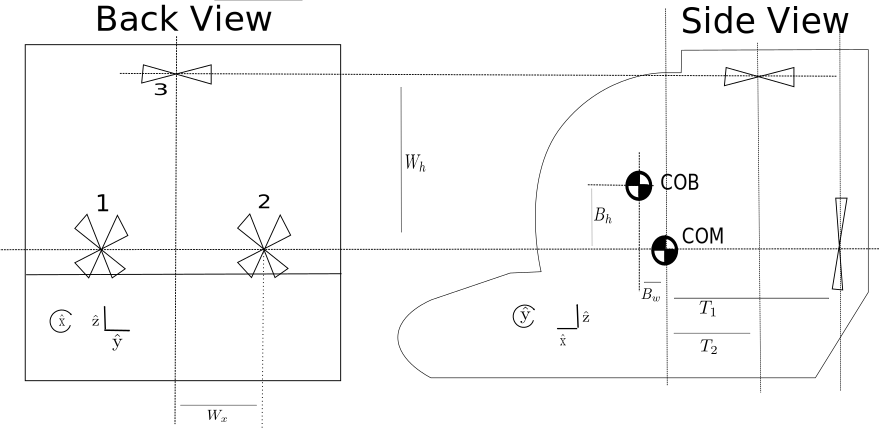

In [3]:
SVG(filename='openrov2.svg')

# Define Variables

constants:

- $m_A$: Mass of the Rov.
- $T_1$: Distance from COM to back thruster axis.
- $T_2$: Distance from COM to upper thruster axis.
- $W_x$: distance from center axis to back thruster axis.
- $W_h$: distance from center axis to upper thruster.
- $B_h$: the z messure of COB (center of bouyency) distance from COG (center of gravity) 
- $B_h$: the x messure of COB distance from COG.

In [4]:
# Inertial Reference Frame
N = me.ReferenceFrame('N')

# Define a world coordinate origin
O = me.Point('O')
O.set_vel(N, 0)

In [5]:
#generelized coordinates
#q0..3 = xyz positions  q4..6 = yaw,pitch,roll rotations
q = list(me.dynamicsymbols('q0:6'))
#generlized speeds
u = list(me.dynamicsymbols('u0:6'))

kin_diff=Matrix(q).diff()-Matrix(u)
#print(me.vlatex(kin_diff))
mprint(kin_diff)

\left[\begin{matrix}- u_{0} + \dot{q}_{0}\\- u_{1} + \dot{q}_{1}\\- u_{2} + \dot{q}_{2}\\- u_{3} + \dot{q}_{3}\\- u_{4} + \dot{q}_{4}\\- u_{5} + \dot{q}_{5}\end{matrix}\right]


⎡-u₀ + q₀̇⎤
⎢         ⎥
⎢-u₁ + q₁̇⎥
⎢         ⎥
⎢-u₂ + q₂̇⎥
⎢         ⎥
⎢-u₃ + q₃̇⎥
⎢         ⎥
⎢-u₄ + q₄̇⎥
⎢         ⎥
⎣-u₅ + q₅̇⎦

In [6]:
# Constants for the Robot Body
Wx = symbols('W_x')                                     # 2*w is the width between thrusters
Wh = symbols('W_h')                                    
T1 = symbols('T_1')                                     # Distance between thruster base and center of mass
T2 = symbols('T_2')                                     
Bh = symbols('B_h')                                     
Bw = symbols('B_w')                                     

m_b = symbols('m_b')                                 # Mass of the body
v_b = symbols('v_b') # Volume of the body
mu = symbols('\mu') #drag
mu_r = symbols('\mu_r') #rotational drag
g = symbols('g')
I = list(symbols('Ixx, Iyy, Izz'))             # Moments of inertia of body


In [7]:
# Robot Reference Frame
Rz=N.orientnew('R_z', 'Axis', (q[3+2], N.z))
Rz.set_ang_vel(N,u[3+2]*N.z)

Ry=Rz.orientnew('R_y', 'Axis', (q[3+1], Rz.y))
Ry.set_ang_vel(Rz,u[3+1]*Rz.y)

R=Ry.orientnew('R', 'Axis', (q[3+0], Ry.x))
R.set_ang_vel(Ry,u[3+0]*Ry.x)


# Center of mass of body
COM = O.locatenew('COM', q[0]*N.x + q[1]*N.y + q[2]*N.z)

# Set the velocity of COM
COM.set_vel(N, u[0]*N.x + u[1]*N.y + u[2]*N.z)

#center of bouyency
COB = COM.locatenew('COB', R.x*Bw+R.z*Bh)
COB.v2pt_theory(COM, N, R);
#COB.set_vel(R,0);
#print(me.vlatex(R.dcm(N)))
#mprint(Rz.ang_vel_in(N).express(N))
#mprint(q[0]*N.x + q[1]*N.y + q[2]*N.z)
#mprint(u[0]*N.x + u[1]*N.y + u[2]*N.z)
#COB.pos_from(O)-COM.pos_from(O)
COM.vel(N)+R.ang_vel_in(N).cross(COB.pos_from(COM))#.express(N)

In [8]:
COB

COB

In [9]:
R.ang_vel_in(N)

In [10]:
mprint(COB.pos_from(COM))

B_{w}\mathbf{\hat{r}_x} + B_{h}\mathbf{\hat{r}_z}


In [11]:
mprint(COB.pos_from(O))

B_{w}\mathbf{\hat{r}_x} + B_{h}\mathbf{\hat{r}_z} + q_{0}\mathbf{\hat{n}_x} + q_{1}\mathbf{\hat{n}_y} + q_{2}\mathbf{\hat{n}_z}


In [12]:
# Calculate inertia of body
#for the products of inertia we assume symetric body => ixy=0, iyz=0, izx=0
Ib = me.inertia(R, *I , ixy=0, iyz=0, izx=0)
# Create a rigid body object for body
Body = me.RigidBody('Body', COM, R, m_b, (Ib, COM))
Ib

In [13]:
# Points of thrusters
L1 = COM.locatenew('L_1', -R.x*T1+Wx*R.y)
L2 = COM.locatenew('L_2', -R.x*T1-Wx*R.y)
L3 = COM.locatenew('L_3', -R.x*T2-Wh*R.z)

# Set the velocity of points 
L1.v2pt_theory(COM, N, R)
L2.v2pt_theory(COM, N, R)
L3.v2pt_theory(COM, N, R);
-R.x*T1+Wx*R.y

## Calculating hydrodynamic drag

https://en.wikipedia.org/wiki/Drag_(physics)

for slow moving objects with non turbulant flow the drag is proportional to the velocity and can be written as:

$F_{D}\,=\mu \,v$

In [14]:
v=N.x*u[0]+N.y*u[1]+N.z*u[2]
Fd=-v*mu
Fd

In [15]:
#thrust forces symbols
F1, F2, F3 = symbols('f_1, f_2, f_3') 
Fg = -N.z *m_b * g
Fb = N.z * v_b * 1e3 *g #whight of 1m^3 water in kg (MKS units)
mprint(Fb)

1000.0 g v_{b}\mathbf{\hat{n}_z}


In [16]:
#### adding dumping Torqe for each rotation
T_z=(Rz,-u[3+2]*N.z*mu_r) #rotaional dumping Torqe
T_y=(Ry,-u[3+1]*Rz.y*mu_r) #rotaional dumping Torqe
T_x=(R,-u[3+0]*Ry.x*mu_r) #rotaional dumping Torqe
mprint(T_x[1])

-  \mu_r u_{3}\mathbf{\hat{r_y}_x}


In [17]:
kane = me.KanesMethod(N, q_ind=q, u_ind=u, kd_eqs=kin_diff)

In [18]:
bodies = (Body,)
loads = (
    (L1, F1 * R.x),
    (L2, F2 * R.x),
    (L3, F3 * R.z), 
    (COM, Fg ), 
    (COB, Fb ), 
    (COM, Fd ),
    T_x,
    T_y,
    T_z
    )

fr, frstar = kane.kanes_equations(loads=loads, bodies=bodies)

In [19]:
#u_dot=trigsimp(trigsimp(kane.mass_matrix).inv()*trigsimp(kane.forcing))
u_dot=kane.mass_matrix.inv()*kane.forcing
u_dot.atoms(Symbol)

In [20]:
mprint(F1 * R.x)

f_{1}\mathbf{\hat{r}_x}


In [21]:
subs=[(Wx,0.1),
    (Wh,0.15),
    (T1,0.1),
    (T2,0.05),
    (Bh,0.08),
    (Bw,0.01),
    (m_b,1.0),
    (v_b,0.001),
    (mu,0.3),
    (mu_r,0.2),
    (g,9.8),
    (I[0],0.5),
    (I[1],0.5),
    (I[2],0.5)
     ]
numerical_constants = [
                            0.1,  # Wx [m]
                            0.15,  # Wh [m]
                            0.1,  # T1 [m]
                            0.05,  # T2 [m]
                            0.08,  # Bh [m]
                            0.01,  # Bw [m]
                            1.0,  # m_b [kg]
                            0.001 ,  # v_b [M^3]
                            0.3,  # mu
                            0.2,  # mu_r
                            9.8,  # g MKS
                            0.5,  # Ixx [kg*m^2]
                            0.5,  # Iyy [kg*m^2]
                            0.5,  # Izz [kg*m^2]
                               ]
                             

In [22]:
u_dot_simp=u_dot.subs(subs)
u_dot_simp=trigsimp(u_dot_simp)

In [23]:
import time


In [24]:
km_simp=trigsimp(kane.mass_matrix)
kf_simp=trigsimp(kane.forcing)
def get_next_state_slow(curr_q,curr_u,control,curr_t,dt,subs):
    #for i in range(len(q_vec)):
    rg=range(len(curr_q))
    subsqf=[(q[i],curr_q[i]) for i in rg] + [(u[i],curr_u[i]) for i in rg]+subs
    forces=control(curr_t)
    subsqf+=[(F1,forces[0]),(F2,forces[1]),(F3,forces[2])]
    if 0:
        u_dot_f=u_dot_simp.subs(subsqf).evalf()
    else:
        km=km_simp.subs(subsqf).evalf()
        kf=kf_simp.subs(subsqf).evalf()
        u_dot_f=km.inv()*kf
    #print('--',u_dot_f)
    u_dot_f=np.array(u_dot_f).flatten()
    next_q=curr_q+curr_u*dt
    next_u=curr_u+u_dot_f*dt
    return next_q,next_u

In [25]:
from sympy import lambdify
def get_next_state_lambda(subs):
    u_dot_simp_q_u_f=u_dot_simp.subs(subs)
    return lambdify((q,u,F1,F2,F3),u_dot_simp_q_u_f)

def get_next_state(curr_q,curr_u,control,curr_t,dt,lamb):
    forces=control(curr_t)
    u_dot_f=lamb(curr_q,curr_u,*forces).flatten()
    next_q=curr_q+curr_u*dt
    next_u=curr_u+u_dot_f*dt
    return next_q,next_u
#test lambdify
qq=np.zeros(6)
uu=np.zeros(6)
lamb=get_next_state_lambda(subs)
lamb(qq,uu,0,0,0)

array([[ 0.   ],
       [ 0.   ],
       [ 0.   ],
       [ 0.   ],
       [-0.196],
       [ 0.   ]])

In [26]:
def plot():
    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(t, y[:, :3])
    plt.legend([latex(s, mode='inline') for s in 'xyz'])
    plt.title('a) Position vs Time')
    plt.subplot(2,2,2)
    plt.plot(t, np.rad2deg(y[:, 3:6]))
    plt.legend([latex(s, mode='inline') for s in 'ypr'])
    plt.title('b) Rotations vs Time')
    plt.subplot(2,2,3)
    plt.title('c) XY plane plot')
    plt.plot(y[:,0],y[:,1])
    plt.axis('equal')
    plt.subplot(2,2,4)
    plt.plot(t, np.rad2deg(y[:, 9:12]))
    plt.legend([latex(s, mode='inline') for s in ['Rz','Ry','Rx']])
    plt.title('d) Angular velocities')


In [27]:
def controller(t):
    if t<20:
        return [0.0,0.0,0]
    else:
        return [-0.8,-0.5,0]


In [28]:
curr_q = np.zeros(6)
curr_u = np.zeros(6)
frames_per_sec = 60.0
final_time = 40.0
dt=1.0/frames_per_sec
y=[]
curr_time=0
t = np.linspace(0.0, final_time, int(final_time * frames_per_sec))
lamb=get_next_state_lambda(subs)
for curr_time in t:
    #next_q,next_u=get_next_state(curr_q,curr_u,controller,curr_time,dt,subs)
    next_q,next_u=get_next_state(curr_q,curr_u,controller,curr_time,dt,lamb)
    next_q,next_u=next_q.flatten(),next_u.flatten()
    y.append(np.hstack((next_q,next_u)))
    curr_q,curr_u=next_q,next_u
y=np.array(y,dtype='float32')


<IPython.core.display.Javascript object>


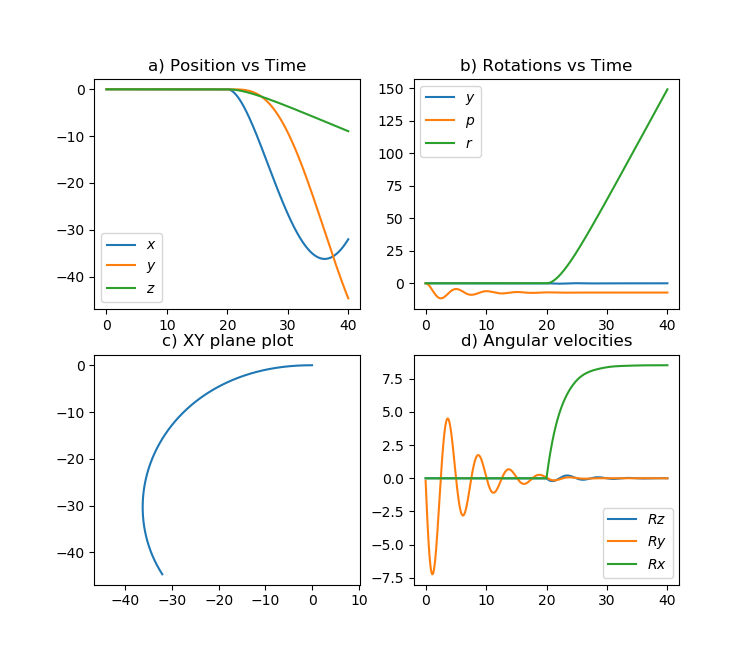

In [29]:
plot()